In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
if os.getcwd()[:5] == '/rds/':
    sys.path.append('/rds/general/user/ll1917/home/esig') # to add when running on remote Jupyter server
    os.chdir('/rds/general/user/ll1917/home/esig') # to add when running on remote Jupyter server

In [131]:
import numpy as np

from lib.esig import expected_signature_estimate 
from lib.data.generate import generate_BM, generate_fBm, generate_MCAR, generate_Heston
from lib.data.utils import chop_and_shift

In [15]:
import matplotlib.pyplot as plt
import os
import pickle
from functools import partial

process = 'BM'
Ns = [2, 4, 8]
n_samples = 10_000
max_depth = 3
dims = 2
T = 1
seed = 0
H = 0.75
independent_paths = True

# generate most granular sample
N_max=max(Ns)
if process == 'BM':
    generate_fn=generate_BM
elif process == 'fBm':
    generate_fn=partial(generate_fBm, H=H, use_multiprocessing=True, chunks=10)
else:
    raise ValueError(f'Unkown process={process}.')

if independent_paths:
    paths=generate_fn(batch=n_samples*N_max, length=2**N_max, dims=dims, T=T, seed=seed).reshape((n_samples, N_max, 2**N_max + 1, dims))
else:
    paths=generate_fn(batch=n_samples, length=N_max * 2**N_max, dims=dims, T=N_max*T, seed=seed)
    paths=chop_and_shift(paths, chops=2**N_max)

esig_estimates = {}
martingale_esig_estimates = {}

for N in Ns:
    paths_N = paths[:, :N, ::2**(N_max - N), :]
    esig_estimates[N] = expected_signature_estimate(paths_N, max_depth, martingale_indices=None)
    martingale_esig_estimates[N] = expected_signature_estimate(paths_N, max_depth, martingale_indices=list(range(dims)))

In [8]:
# with open(f'./simulations/data/{process}_paths.pickle', 'wb') as f:
#     pickle.dump(paths, f)

# with open(f'./simulations/data/{process}_esig_estimates.pickle', 'wb') as f:
#     pickle.dump(esig_estimates, f)

# with open(f'./simulations/data/{process}_martingale_esig_estimates.pickle', 'wb') as f:
#     pickle.dump(martingale_esig_estimates, f)

C:\Users\ll1917\AppData\Local\Temp\ipykernel_23920\2390896927.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


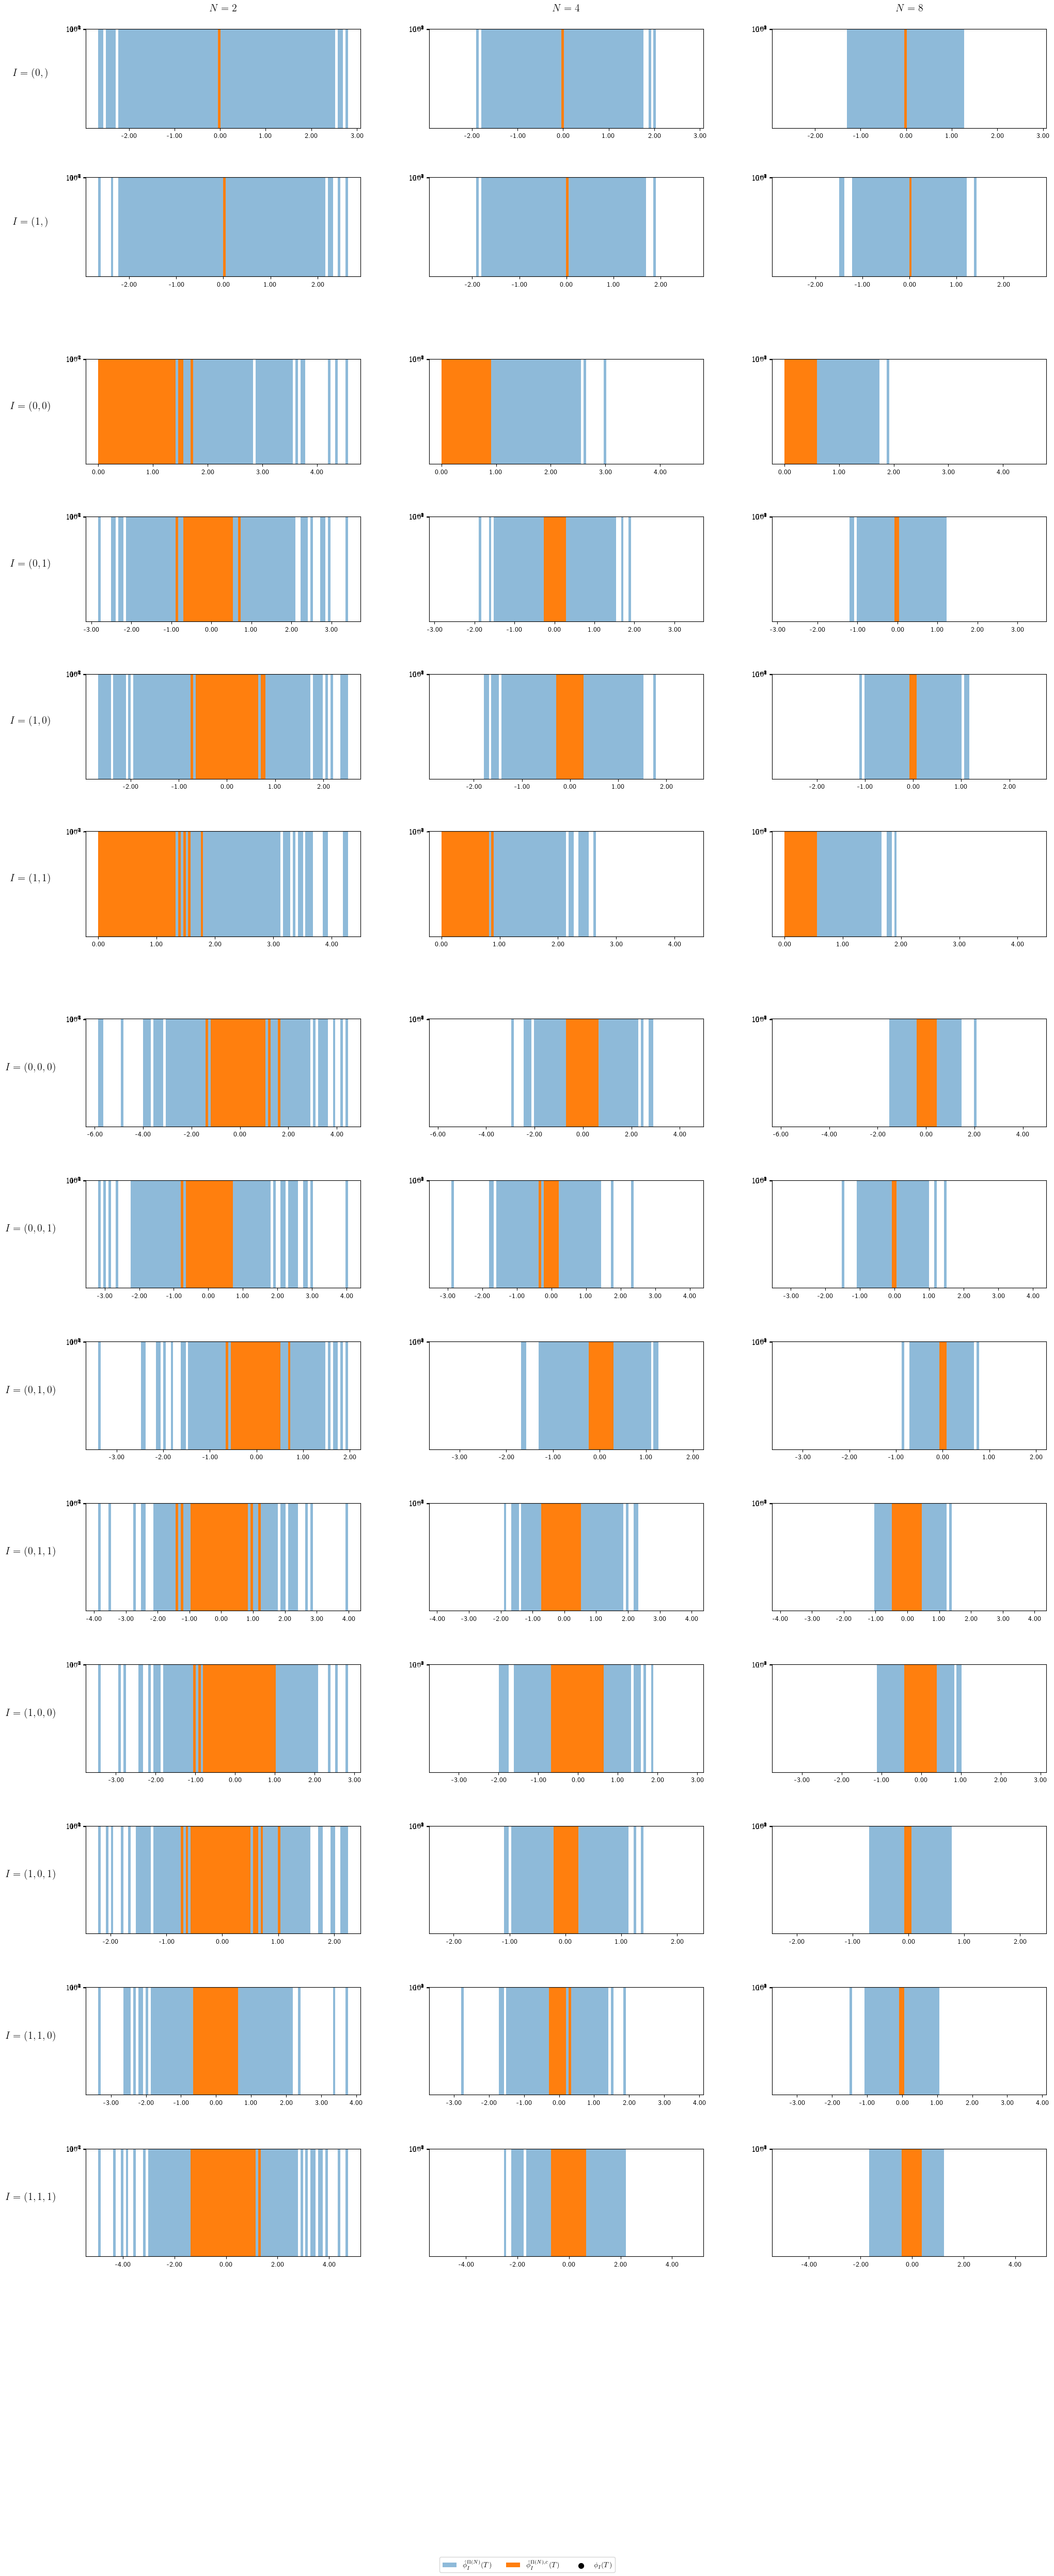

In [33]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
from matplotlib import rcParams
from lib.utils import sig_idx_to_word
from lib.brownian_motion.esig import expected_signature_BM


rcParams.update({'text.usetex': True})

dims = 2
max_depth = 3
esig_length = sum([dims**i for i in range(1, max_depth+1)])

# Main figure
fig = plt.figure(figsize=(len(Ns) * 8, esig_length * 4))
outer_grid = gridspec.GridSpec(esig_length, len(Ns), wspace=1., hspace=1.)

with_correction = True
with_exact = True
row_start = 0

for depth in range(1, max_depth + 1):
    num_rows = dims ** depth
    row_end = row_start + num_rows
    

    inner_grid = gridspec.GridSpecFromSubplotSpec(num_rows, len(Ns), subplot_spec=outer_grid[row_start:row_end, :], wspace=.25, hspace=.5)

    for i in range(num_rows):
        y_max = 0
        axes = []
        for j, N in enumerate(Ns):
            ax = fig.add_subplot(inner_grid[i, j])
            I = sig_idx_to_word(row_start + i, dims)
            if j == 0:
                ax.set_ylabel(
                    fr"""\Large{{$I = {I}$}}""",
                    rotation = 0,
                    labelpad = 50
                )
            if row_start + i == 0:
                ax.set_title(
                    fr"""\Large{{$N = {N}$}}""",
                    pad = 25
                )

            if j == 0:
                n, bins, patches = ax.hist(esig_estimates[N][:, row_start + i], bins = 100, label=r'$\hat{\phi}^{\Pi(N)}_I(T)$', alpha = 0.5 if with_correction else 1, density=True)
                x_lims = ax.get_xlim()
            elif j > 0:
                ax.hist(esig_estimates[N][:, row_start + i], bins = bins, label=r'$\hat{\phi}^{\Pi(N)}_I(T)$', alpha = 0.5 if with_correction else 1, density=True)
                ax.set_xlim(*x_lims)
            
            if with_correction:
                ax.hist(martingale_esig_estimates[N][:, row_start + i], bins=bins, label=r'$\hat{\phi}^{\Pi(N), c}_I(T)$', density=True)
            
            if with_exact:
                if process == 'BM':
                    exact_value = expected_signature_BM(I, T=T, d=dims)
                else:
                    raise ValueError(f'Unknown/unimplemented exact expected signature for process = {process}')
                ax.scatter(exact_value, 0, s=50, color='black', label=r'$\phi_I(T)$', zorder=3, clip_on=False)


            y_max = max(y_max, ax.get_ylim()[-1])
            
            ax.xaxis.set_major_formatter(ScalarFormatter())
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: f'{val:.2f}')) 
            ax.set_yticks([])
            ax.set_yticklabels([])

            axes.append(ax)
        
        # set same y_lims
        for ax in axes:
            ax.set_ylim(0, y_max)
            if with_correction:
                ax.set_yscale('log')

    row_start = row_end

handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
fig.legend(unique_labels.values(), unique_labels.keys(), loc='lower center', ncol=len(unique_labels))

fig.tight_layout()
plt.show()